In [261]:
import pandas as pd
import datetime as dt
import numpy as np
from sklearn.externals import joblib
from keras.models import load_model

%matplotlib inline

In [262]:
date_parser = lambda x: dt.datetime.strptime(x[0:16], '%d.%m.%Y %H:%M')

In [263]:
data_raw1 = pd.read_csv('./raw_data/Total Load - Day Ahead Forecast - Actual_201501010000-201601010000.csv',
                        index_col=0, date_parser=date_parser)

data_raw2 = pd.read_csv('./raw_data/Total Load - Day Ahead Forecast- Actual_201601010000-201701010000.csv',
                        index_col=0, date_parser=date_parser)

data_raw3 = pd.read_csv('./raw_data/Total Load - Day Ahead Forecast - Actual_201701010000-201801010000.csv',
                        index_col=0, date_parser=date_parser)


data_raw1_f = pd.read_csv('./raw_data/Generation Forecasts - Day Ahead for Wind and Solar_201501010000-201601010000.csv',
                        index_col=0, date_parser=date_parser)

data_raw2_f = pd.read_csv('./raw_data/Generation Forecasts - Day Ahead for Wind and Solar_201601010000-201701010000.csv',
                        index_col=0, date_parser=date_parser)

data_raw3_f = pd.read_csv('./raw_data/Generation Forecasts - Day Ahead for Wind and Solar_201701010000-201801010000.csv',
                        index_col=0, date_parser=date_parser)

data_raw= pd.concat([data_raw1, data_raw2, data_raw3, data_raw1_f, data_raw2_f, data_raw3_f])

In [264]:
data_raw = data_raw.replace(['-', 'n/e'], np.NaN).dropna(how='all')

In [265]:
data_raw.columns

Index(['Actual Total Load [MW] - BZN|DE-AT-LU',
       'Day-ahead Total Load Forecast [MW] - BZN|DE-AT-LU',
       'Generation - Solar  [MW] (D) / BZN|DE-AT-LU',
       'Generation - Sum [MW] (D) / BZN|DE-AT-LU',
       'Generation - Wind Offshore  [MW] (D) / BZN|DE-AT-LU',
       'Generation - Wind Onshore  [MW] (D) / BZN|DE-AT-LU'],
      dtype='object')

In [266]:
# ['Day-ahead Total Load Forecast [MW] - BZN|DE-AT-LU']
data = pd.DataFrame(data_raw.astype(float))

data.columns = ['DA_load_forecast', 'DA_load_actual', 'solar', 'sum', 'offshore', 'onshore']

In [267]:
any(data.dropna().index.to_series().diff() > pd.Timedelta('01:00:00'))

False

In [268]:
data = data.resample('1H').mean()

In [269]:
data = data.loc[:'2017-08-31', ['DA_load_forecast', 'solar', 'offshore', 'onshore']]

In [270]:
# still missing data, but we need the full index for assignment of bottleneck features (len of arrays has
# to be the same). Missing values will be dropped after transforming to array.
data.iloc[pd.isnull(data).any(1).nonzero()[0]]

,DA_load_forecast,solar,offshore,onshore
2015-01-04 00:00:00,48793.50,0.00,NaN,17153.50
2015-01-04 01:00:00,44632.25,0.00,NaN,19203.50
2015-01-04 02:00:00,42616.75,0.00,NaN,19459.50
2015-01-04 03:00:00,41546.25,0.00,NaN,19656.00
2015-01-04 04:00:00,41655.00,0.00,NaN,19920.50
2015-01-04 05:00:00,41122.50,0.00,NaN,19759.75
2015-01-04 06:00:00,40416.75,0.00,NaN,19457.00
2015-01-04 07:00:00,43349.25,0.00,NaN,19114.25
2015-01-04 08:00:00,46463.75,108.50,NaN,18739.00
2015-01-04 09:00:00,49440.50,1304.50,NaN,18290.00


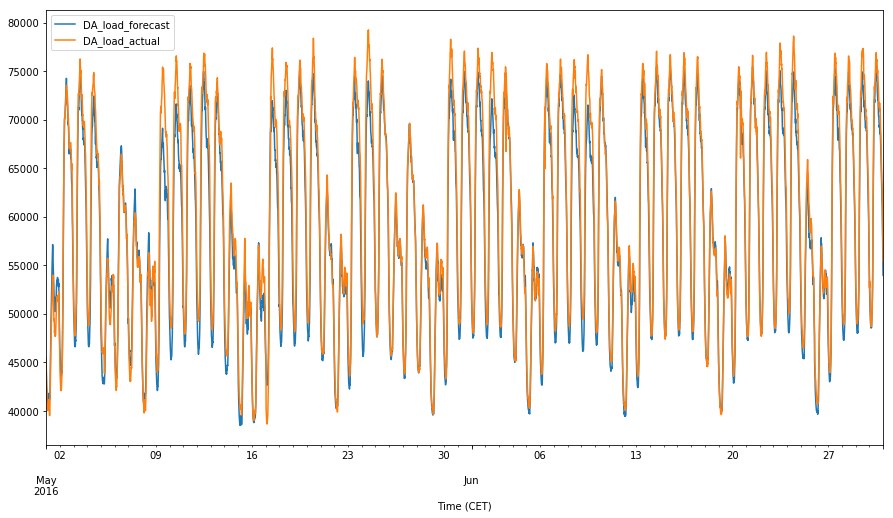

In [32]:
data['2016-05':'2016-06'].plot(figsize=(15, 8))

In [271]:
data_test = data['2017']
data_train = data[data.index.year != 2017]

In [272]:
da_raw = pd.read_csv('./raw_data/EPEX_spot_DA_auction_hour_prices_20070720-20170831.csv',
                     index_col=0, parse_dates=True)
da_raw.head(n=5)

,DA_price
2007-07-20 00:00:00,25.69
2007-07-20 01:00:00,26.45
2007-07-20 02:00:00,24.33
2007-07-20 03:00:00,23.57
2007-07-20 04:00:00,18.96


In [273]:
# keep raw data of the test set for model evaluation
test_raw = da_raw['2017']

In [274]:
da_scaler = joblib.load('./models/DA_price_scaler.pkl')

In [275]:
da_prep = pd.DataFrame(index=da_raw.index)

# calculate quantiles and inter-quantile range of the data
q75 = da_raw['DA_price'].quantile(.75)
q25 = da_raw['DA_price'].quantile(.25)
IQR = q75 - q25

# values larger (smaller) than q75 (q25) plus 'tol' times IQR get replaces by that value
tol = 3
da_prep['DA_price'] = da_raw['DA_price'].apply(lambda x: q75 + tol * IQR if (x > q75 + tol * IQR) else x)
da_prep['DA_price'] = da_prep['DA_price'].apply(lambda x: q25 - tol * IQR if (x < q75 - tol * IQR) else x)

da_prep['DA_price'] = da_scaler.transform(da_prep['DA_price'].reshape(-1, 1))
# include time lags of timeseries data for 1 week = 7 * 24h = 168h
lags = 168
for l in range(1, lags+1):
    da_prep['l_{}'.format(l)] = da_prep['DA_price'].shift(l)
    
da_prep.dropna(inplace=True)

/home/fritz/opt/anaconda3/envs/datascience/lib/python3.6/site-packages/ipykernel_launcher.py:13: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  del sys.path[0]


In [276]:
# create feature and label dataframes
prelim_features = da_prep.drop('DA_price', axis=1)
prelim_labels = pd.DataFrame(da_prep['DA_price'])

# format labels to 24 hour output range
for i in range(0, 24):
    prelim_labels['t_{}'.format(i)] = prelim_labels['DA_price'].shift(-i)
prelim_labels.drop('DA_price', axis=1, inplace=True)

# apply one-day discretization to the data
labels = prelim_labels[prelim_labels.index.hour == 0]
features = prelim_features[prelim_features.index.hour == 0]

features_train = features['2015':'2016']
features_test = features['2017-01-01':'2017-08-31']
labels_train = labels['2015':'2016']
labels_test = labels['2017-01-01':'2017-08-31']

samples_train = len(features_train)
samples_test = len(features_test)
timesteps = 168

# convert pandas data frames to numpy ndarrays
features_train = features_train.as_matrix().reshape(samples_train, timesteps, 1)
features_test = features_test.as_matrix().reshape(samples_test, timesteps, 1)
labels_train = labels_train.as_matrix()
labels_test = labels_test.as_matrix()

# check for correct data shape
features_train.shape, labels_train.shape

((731, 168, 1), (731, 24))

In [277]:
timeseries_model = load_model('./models/timeseries_final_model_tuning.hdf5')

In [278]:
features_train_lin = features_train.reshape(features_train.shape[0], features_train.shape[1])
features_test_lin = features_test.reshape(features_test.shape[0], features_test.shape[1])  
bottleneck_features_train = timeseries_model.predict([features_train, features_train_lin])
bottleneck_features_test = timeseries_model.predict([features_test, features_test_lin])

In [279]:
bneck_train_unscaled = da_scaler.inverse_transform(bottleneck_features_train)
bneck_test_unscaled = da_scaler.inverse_transform(bottleneck_features_test)

In [280]:
input_tensors_train = np.concatenate((data_train.as_matrix(), np.expand_dims(bneck_train_unscaled.flatten(), 1)), axis=1)
input_tensors_test = np.concatenate((data_test.as_matrix(), np.expand_dims(bneck_test_unscaled.flatten(), 1)), axis=1)

In [281]:
output_tensors_train = da_scaler.inverse_transform(labels_train).flatten()
output_tensors_test = da_scaler.inverse_transform(labels_test).flatten()

In [282]:
output_tensors_train = output_tensors_train.reshape(output_tensors_train.shape[0], -1)
output_tensors_test = output_tensors_test.reshape(output_tensors_test.shape[0], -1)

In [283]:
# drop NaN values. Done here because of array length sensitivity
input_tensors_train = input_tensors_train[~np.isnan(input_tensors_train).any(axis=1)]
output_tensors_train = output_tensors_train[~np.isnan(input_tensors_train).any(axis=1)]

/home/fritz/opt/anaconda3/envs/datascience/lib/python3.6/site-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 17544 but corresponding boolean dimension is 17518
  This is separate from the ipykernel package so we can avoid doing imports until


In [284]:
# drop NaN values. Done here because of array length sensitivity
input_tensors_test = input_tensors_test[~np.isnan(input_tensors_test).any(axis=1)]
output_tensors_test = output_tensors_test[~np.isnan(input_tensors_test).any(axis=1)]

/home/fritz/opt/anaconda3/envs/datascience/lib/python3.6/site-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 5832 but corresponding boolean dimension is 5831
  This is separate from the ipykernel package so we can avoid doing imports until


In [367]:
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge, LassoLars
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

In [327]:
scaler = MinMaxScaler()
scaler_output = MinMaxScaler()

In [334]:
scaled_input_tensors_train = scaler.fit_transform(input_tensors_train)
scaled_input_tensors_test = scaler.transform(input_tensors_test)
scaled_output_tensors_train = scaler_output.fit_transform(output_tensors_train)

In [424]:
regressor = ElasticNet()

In [429]:
regressor.fit(input_tensors_train[:, [2, 3, 4]], output_tensors_train)

ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [430]:
pred = regressor.predict(input_tensors_test[:, [2, 3, 4]])

In [431]:
pred

array([ 29.11660568,  26.57027981,  27.44263072, ...,  37.73676512,
        35.8277856 ,  31.36154593])

In [432]:
print(mean_absolute_error(output_tensors_test, pred))

5.65103133347


In [433]:
from keras.models import Model, load_model
from keras.layers import Input, Add
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.layers.convolutional import Conv1D
from keras.callbacks import ModelCheckpoint
from keras.regularizers import l1_l2

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import json

In [451]:
lin_input_layer = Input(shape=(scaled_input_tensors_train.shape[1],))
x = Dense(10)(lin_input_layer)
x = Dense(1)(x)

model = Model(inputs=[lin_input_layer], outputs=[x])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 5)                 0         
_________________________________________________________________
dense_9 (Dense)              (None, 10)                60        
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 11        
Total params: 71
Trainable params: 71
Non-trainable params: 0
_________________________________________________________________


In [452]:
model.compile(loss='mse', optimizer='adam')
checkpoint = ModelCheckpoint('./models/timeseries_plus_forecasts.hdf5', save_best_only=True)
hist = model.fit(scaled_input_tensors_train, scaled_output_tensors_train,
                 callbacks=[checkpoint], 
                 verbose=1, batch_size=10, epochs=10)

# best = load_model('./models/timeseries_plus_forecasts.hdf5')
pred = model.predict(scaled_input_tensors_test)
pred = scaler_output.inverse_transform(pred.flatten().reshape(-1, 1))


Epoch 1/10
17518/17518 [==============================] - 2s - loss: 0.0060     
Epoch 2/10
 1070/17518 [>.............................] - ETA: 2s - loss: 0.0046

/home/fritz/opt/anaconda3/envs/datascience/lib/python3.6/site-packages/keras/callbacks.py:405: RuntimeWarning: Can save best model only with val_loss available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


17518/17518 [==============================] - 2s - loss: 0.0042     
Epoch 3/10
17518/17518 [==============================] - 2s - loss: 0.0042     
Epoch 4/10
17518/17518 [==============================] - 2s - loss: 0.0041     
Epoch 5/10
17518/17518 [==============================] - 2s - loss: 0.0041     
Epoch 6/10
17518/17518 [==============================] - 2s - loss: 0.0041     
Epoch 7/10
17518/17518 [==============================] - 2s - loss: 0.0041     
Epoch 8/10
17518/17518 [==============================] - 2s - loss: 0.0041     
Epoch 9/10
17518/17518 [==============================] - 2s - loss: 0.0041     
Epoch 10/10
17518/17518 [==============================] - 2s - loss: 0.0041     


In [453]:
print(mean_absolute_error(output_tensors_test, pred))

6.15115989982
